In [46]:
import os
import math
import numpy as np
import pandas as pd
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt

import mar
import preprocessing

In [2]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
pat_num = 4

In [9]:
mar4 = preprocessing.load_mar_data(data_dir, pat_num)
sickbay4 = preprocessing.load_sickbay_data(data_dir, pat_num)

In [94]:
print(sickbay4.head())

                 time  heart_rate  SpO2  respiratory_rate  \
0 2023-11-13 18:00:01       146.0  96.0              50.0   
1 2023-11-13 18:00:03       147.0  96.0              48.0   
2 2023-11-13 18:00:05       148.0  96.0              45.0   
3 2023-11-13 18:00:07       148.0  96.0              36.0   
4 2023-11-13 18:00:09       149.0  97.0              39.0   

   blood_pressure_systolic  blood_pressure_mean  blood_pressure_diastolic  
0                      NaN                  NaN                       NaN  
1                      NaN                  NaN                       NaN  
2                      NaN                  NaN                       NaN  
3                      NaN                  NaN                       NaN  
4                      NaN                  NaN                       NaN  


In [107]:
sbs4 = preprocessing.load_retro_data(data_dir, pat_num)
sbs4 = sbs4[sbs4['Default'] != 'Y']
sbs4 = sbs4[['time', 'MD_SBS', 'TM_SBS', 'SBS']]

In [105]:
print(mar4)
print(sickbay4)
print(sbs4)

                    time    dose   mar_action  \
0    2023-11-01 20:53:00  130.00  ['New Bag']   
1    2023-11-01 22:15:00   30.00    ['Given']   
2    2023-11-01 23:18:00   30.00   ['Missed']   
3    2023-11-01 23:18:00    0.01   ['Missed']   
4    2023-11-02 00:30:00    6.00    ['Given']   
...                  ...     ...          ...   
4873 2023-12-08 08:56:00   11.20    ['Given']   
4874 2023-12-08 09:00:00    0.00  ['Stopped']   
4875 2023-12-08 09:00:00   20.00    ['Given']   
4876 2023-12-08 09:12:00   20.00    ['Given']   
4877 2023-12-08 09:31:00  400.00    ['Given']   

                                               med_name  
0        ['ACETAMINOPHEN INJECTION 10 MG/ML (JHH PED)']  
1     ['HEPARIN, PORCINE (PF) 10 UNIT/ML INTRAVENOUS...  
2     ['HEPARIN, PORCINE (PF) 10 UNIT/ML INTRAVENOUS...  
3       ['DEXMEDETOMIDINE INFUSION 4 MCG/ML (JHH PED)']  
4                       ['FAMOTIDINE IV 4 MG/ML (PED)']  
...                                                 ...  
4873 

In [11]:
raw_data = preprocessing.load_mat_file(os.path.join(data_dir, "Patient4", "Patient4_SICKBAY_15MIN_1MIN_Retro.mat"))

for key in raw_data.keys():
    if raw_data[key].ndim == 2:
        new = np.empty(raw_data[key].shape[0], dtype=object)

        for j in range(len(new)):
            new[j] = raw_data[key]
        
        raw_data[key] = new

sickbay_df = pd.DataFrame(raw_data)
display(sickbay_df.head())

,x_mag,heart_rate,SpO2,respiratory_rate,blood_pressure_systolic,blood_pressure_mean,blood_pressure_diastolic,sbs,start_time,PRNs
0,"[[0.9844525, 0.99221826, 0.99610144, 0.9961014...","[[126.0, 126.0, 126.0, 126.0, 126.0, 127.0, 12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[20.0, 21.0, 20.0, 20.0, 18.0, 18.0, 21.0, 22...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,[[None]],Y
1,"[[0.9844525, 0.99221826, 0.99610144, 0.9961014...","[[126.0, 126.0, 126.0, 126.0, 126.0, 127.0, 12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[20.0, 21.0, 20.0, 20.0, 18.0, 18.0, 21.0, 22...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,[[None]],Y
2,"[[0.9844525, 0.99221826, 0.99610144, 0.9961014...","[[126.0, 126.0, 126.0, 126.0, 126.0, 127.0, 12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[20.0, 21.0, 20.0, 20.0, 18.0, 18.0, 21.0, 22...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-1,[[None]],N
3,"[[0.9844525, 0.99221826, 0.99610144, 0.9961014...","[[126.0, 126.0, 126.0, 126.0, 126.0, 127.0, 12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[20.0, 21.0, 20.0, 20.0, 18.0, 18.0, 21.0, 22...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-1,[[None]],N
4,"[[0.9844525, 0.99221826, 0.99610144, 0.9961014...","[[126.0, 126.0, 126.0, 126.0, 126.0, 127.0, 12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[20.0, 21.0, 20.0, 20.0, 18.0, 18.0, 21.0, 22...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,[[None]],N


In [ ]:
accel4 = preprocessing.load_accel_data(data_dir, pat_num)

In [7]:
accel4.to_csv(os.path.join(data_dir, "Patient4", "accel_raw.csv"), index=False)

In [19]:
accel4 = accel4.sort_values(by='time', ascending=True).reset_index(drop=True)

In [20]:
print(accel4.head())

                 time         X         Y         Z  IdleSleepMode
0 2023-11-13 17:57:45 -0.441406  0.820312 -0.542969          False
1 2023-11-13 17:57:45 -0.378906  0.925781 -0.621094          False
2 2023-11-13 17:57:45 -0.425781  0.968750 -0.597656          False
3 2023-11-13 17:57:45 -0.496094  1.015625 -0.562500          False
4 2023-11-13 17:57:45 -0.484375  1.027344 -0.468750          False


In [96]:
accel4_downsampled = accel4.iloc[::200].reset_index(drop=True)
accel4_downsampled['time'] = accel4_downsampled['time'].dt.round('S')

In [97]:
print(accel4_downsampled.shape)
print(accel4_downsampled.head())

(643355, 5)
                 time         X         Y         Z  IdleSleepMode
0 2023-11-13 17:57:45 -0.441406  0.820312 -0.542969          False
1 2023-11-13 17:57:47 -0.574219  0.261719 -0.699219          False
2 2023-11-13 17:57:49 -0.117188  0.902344 -0.273438          False
3 2023-11-13 17:57:51 -0.558594 -0.125000 -1.164062          False
4 2023-11-13 17:57:53  0.046875  0.003906 -1.175781          False


In [98]:
accel4_downsampled['a'] = np.sqrt(accel4_downsampled['X']**2 + accel4_downsampled['Y']**2 + accel4_downsampled['Z']**2)
accel4_downsampled.to_csv(os.path.join(data_dir, "Patient4", "accel_downsampled.csv"), index=False)

In [ ]:
mar4_narcotics, mar4_paralytics, mar4_alpha_agonists, mar4_ketamines, mar4_propofols, mar4_etomidates, mar4_benzodiazepines = mar.filter_mar(mar4)

print(mar4_narcotics.shape)
print(mar4_paralytics.shape)
print(mar4_alpha_agonists.shape)
print(mar4_ketamines.shape)
print(mar4_propofols.shape)
print(mar4_etomidates.shape)
print(mar4_benzodiazepines.shape)

(265, 4)
(0, 4)
(506, 4)
(12, 4)
(0, 4)
(0, 4)
(0, 4)


In [60]:
narcotics_half_lives = {'fentanyl': 4.5, 'hydromorphone': 2.5, 'methadone': 19.5}
narcotics_elimination_rates = {med: np.log(2) / (half_life * 60) for med, half_life in narcotics_half_lives.items()}

mar4_fentanyl = mar4_narcotics[mar4_narcotics['med_name'].str.contains('fentanyl', case=False)]

fentanyl_doses = mar.calculate_doses(mar4_fentanyl)

fentanyl_concetrations = mar.calculate_concentrations(fentanyl_doses, narcotics_elimination_rates['fentanyl'])

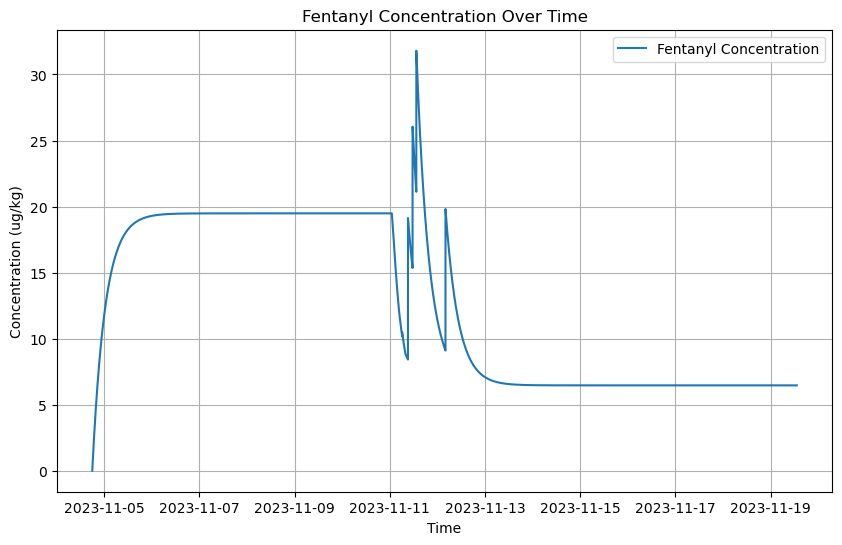

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(fentanyl_concetrations['time'], fentanyl_concetrations['concentration'], label='Fentanyl Concentration')
plt.xlabel('Time')
plt.ylabel('Concentration (ug/kg)')
plt.title('Fentanyl Concentration Over Time')
plt.legend()
plt.grid()
plt.show()

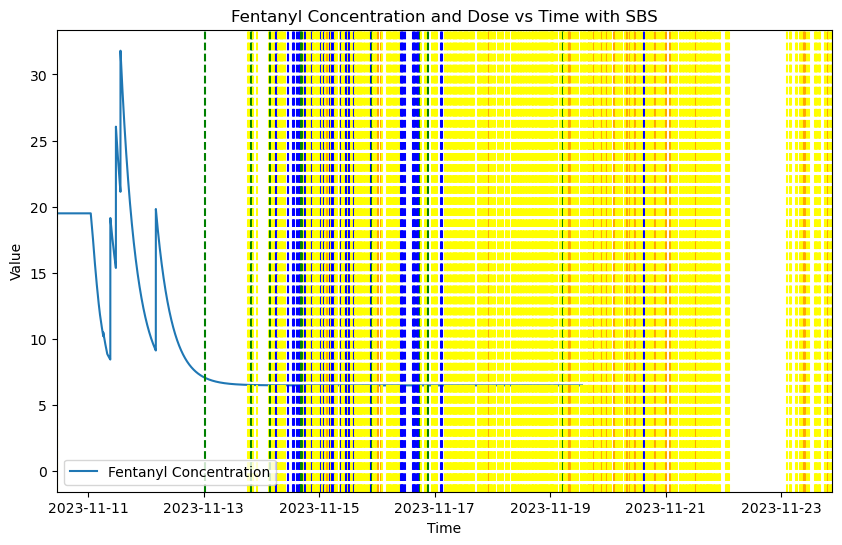

In [108]:
start = sbs4['time'].iloc[1]
end = sbs4['time'].iloc[-1]

plt.figure(figsize=(10, 6))
plt.plot(fentanyl_concetrations['time'], fentanyl_concetrations['concentration'], label='Fentanyl Concentration')
for i in range(1, len(sbs4)):
    if sbs4['TM_SBS'].iloc[i] == -2:
        plt.axvline(x=sbs4['time'].iloc[i], color='blue', linestyle='--')
    elif sbs4['TM_SBS'].iloc[i] == -1:
        plt.axvline(x=sbs4['time'].iloc[i], color='green', linestyle='--')
    elif sbs4['TM_SBS'].iloc[i] == 0:
        plt.axvline(x=sbs4['time'].iloc[i], color='yellow', linestyle='--')
    elif sbs4['TM_SBS'].iloc[i] == 1:
        plt.axvline(x=sbs4['time'].iloc[i], color='orange', linestyle='--')
    elif sbs4['TM_SBS'].iloc[i] == 2:
        plt.axvline(x=sbs4['time'].iloc[i], color='red', linestyle='--')
plt.xlim(start, end)
plt.title('Fentanyl Concentration and Dose vs Time with SBS')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [73]:
mar4_dexmedetomidine = mar4_alpha_agonists[mar4_alpha_agonists['med_name'].str.contains('dexmedetomidine', case=False)]
mar4_clonidine = mar4_alpha_agonists[mar4_alpha_agonists['med_name'].str.contains('clonidine', case=False)]

alpha_agonists_half_lives = {'dexmedetomidine': 2, 'clonidine': 1.25}
alpha_agonists_elimination_rates = {med: np.log(2) / (half_life * 60) for med, half_life in alpha_agonists_half_lives.items()}

dexmedetomidine_doses = mar.calculate_doses(mar4_dexmedetomidine)
clonidine_doses = mar.calculate_doses(mar4_clonidine)

dexmedetomidine_concentrations = mar.calculate_concentrations(dexmedetomidine_doses, alpha_agonists_elimination_rates['dexmedetomidine'])
clonidine_concentrations = mar.calculate_concentrations(clonidine_doses, alpha_agonists_elimination_rates['clonidine'])

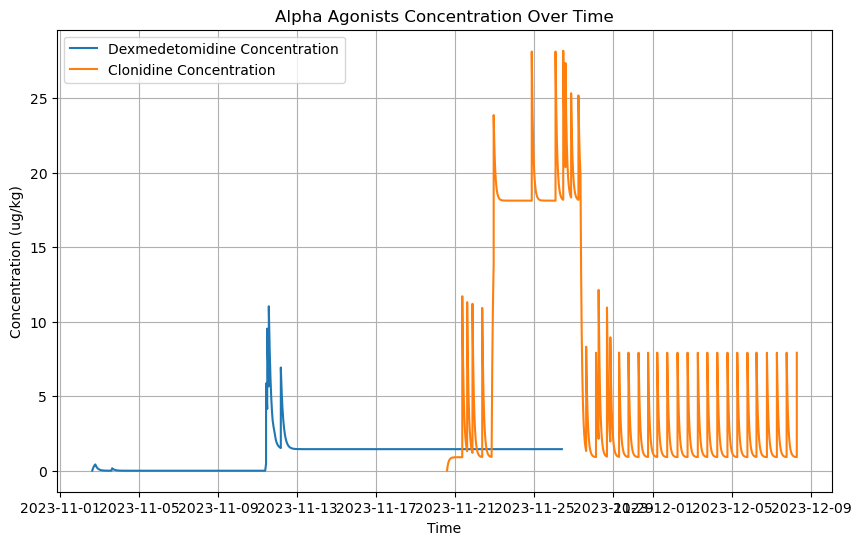

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(dexmedetomidine_concentrations['time'], dexmedetomidine_concentrations['concentration'], label='Dexmedetomidine Concentration')
plt.plot(clonidine_concentrations['time'], clonidine_concentrations['concentration'], label='Clonidine Concentration')
plt.xlabel('Time')
plt.ylabel('Concentration (ug/kg)')
plt.title('Alpha Agonists Concentration Over Time')
plt.legend()
plt.grid()
plt.show()

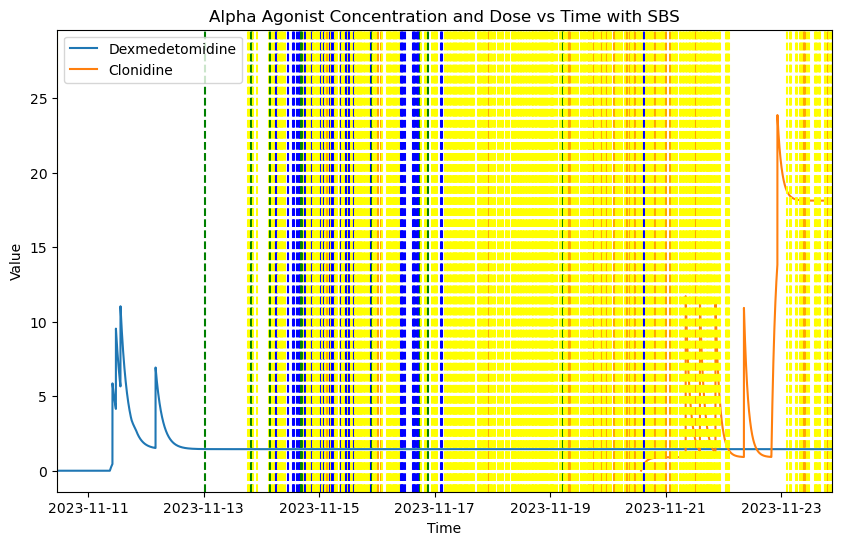

In [109]:
start = sbs4['time'].iloc[1]
end = sbs4['time'].iloc[-1]

plt.figure(figsize=(10, 6))
plt.plot(dexmedetomidine_concentrations['time'], dexmedetomidine_concentrations['concentration'], label='Dexmedetomidine')
plt.plot(clonidine_concentrations['time'], clonidine_concentrations['concentration'], label='Clonidine')
for i in range(1, len(sbs4)):
    if sbs4['TM_SBS'].iloc[i] == -2:
        plt.axvline(x=sbs4['time'].iloc[i], color='blue', linestyle='--')
    elif sbs4['TM_SBS'].iloc[i] == -1:
        plt.axvline(x=sbs4['time'].iloc[i], color='green', linestyle='--')
    elif sbs4['TM_SBS'].iloc[i] == 0:
        plt.axvline(x=sbs4['time'].iloc[i], color='yellow', linestyle='--')
    elif sbs4['TM_SBS'].iloc[i] == 1:
        plt.axvline(x=sbs4['time'].iloc[i], color='orange', linestyle='--')
    elif sbs4['TM_SBS'].iloc[i] == 2:
        plt.axvline(x=sbs4['time'].iloc[i], color='red', linestyle='--')
plt.xlim(start, end)
plt.title('Alpha Agonist Concentration and Dose vs Time with SBS')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [81]:
hr4 = sickbay4[['time', 'heart_rate']]
rr4 = sickbay4[['time', 'respiratory_rate']]

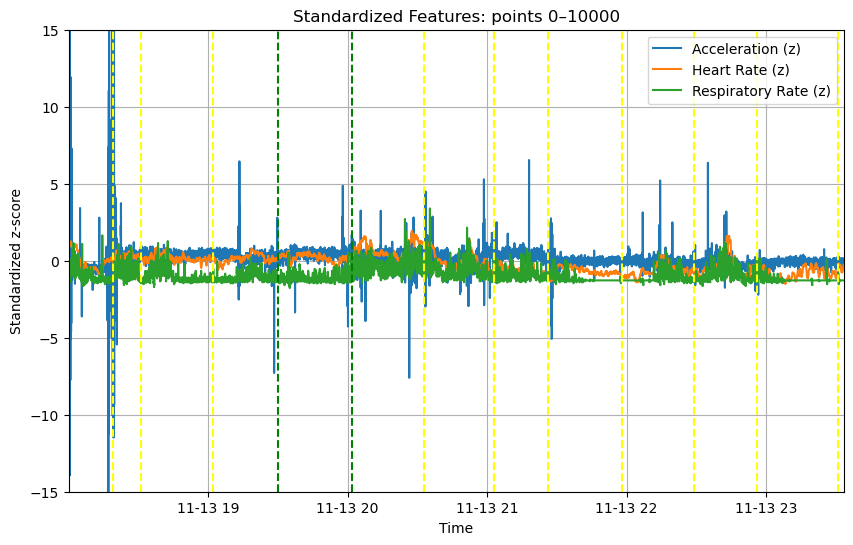

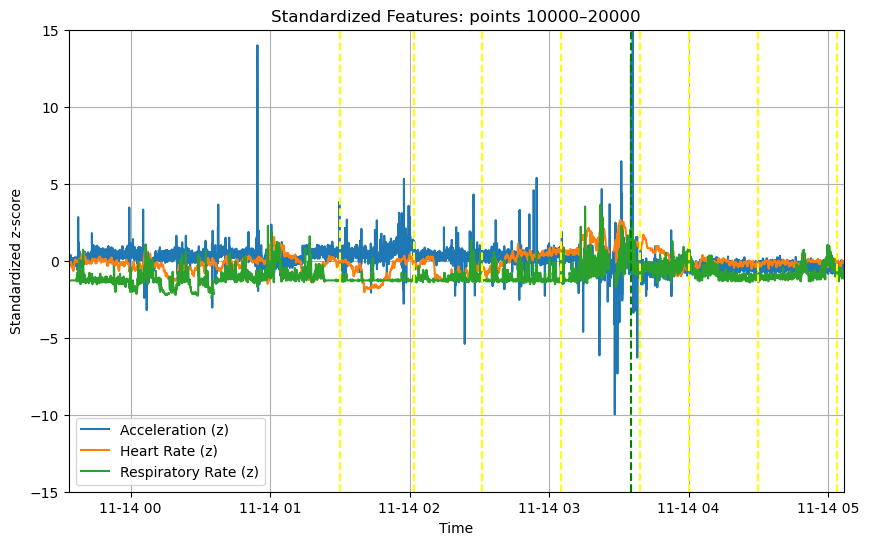

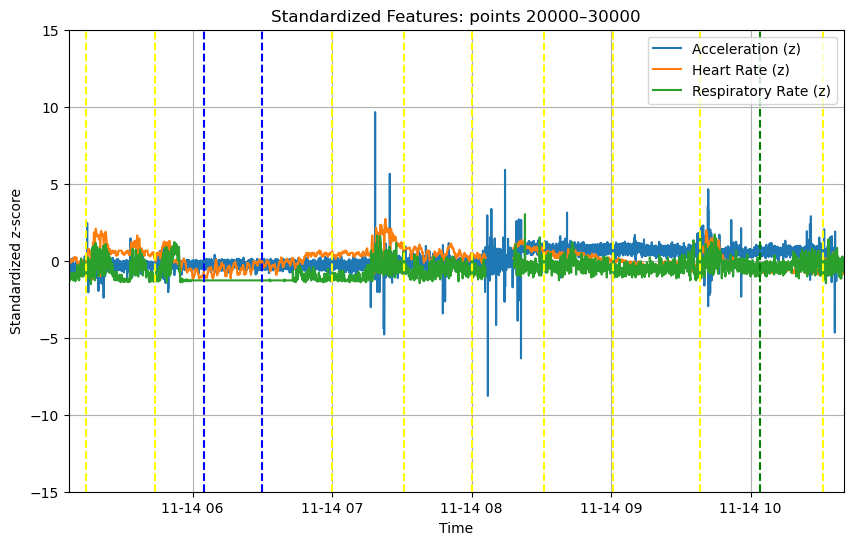

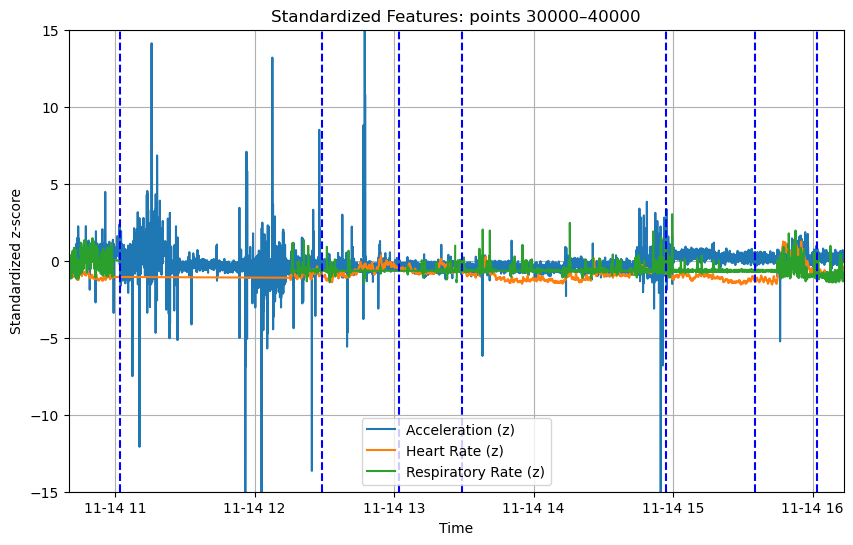

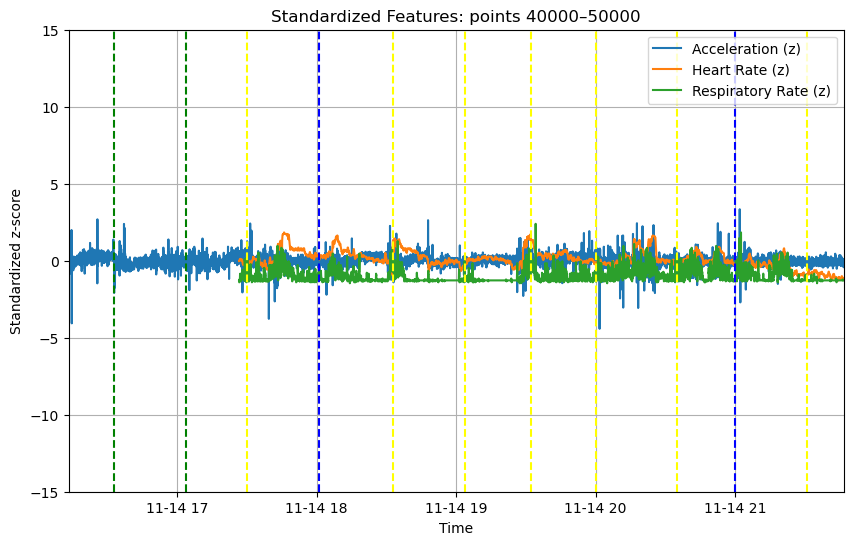

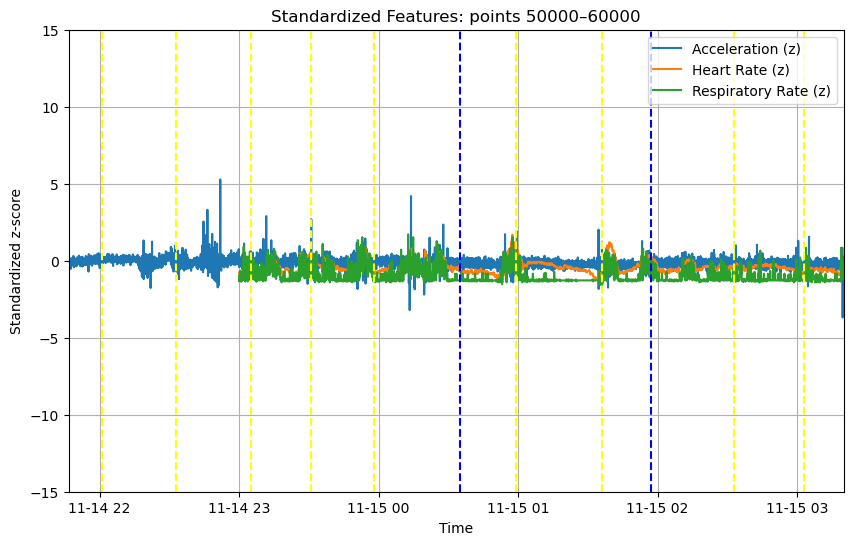

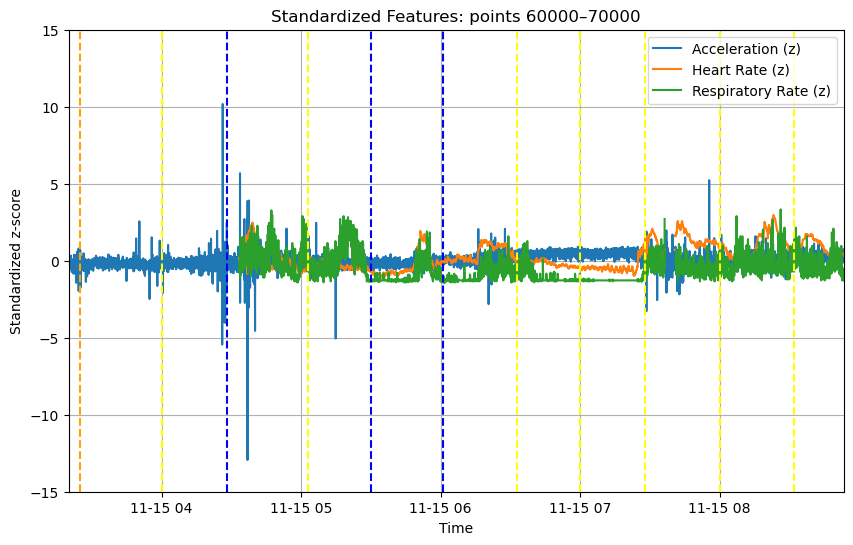

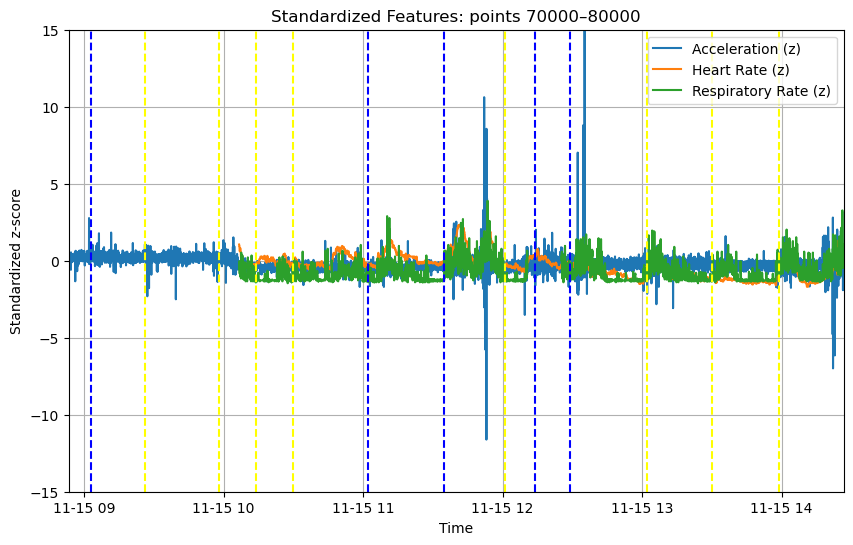

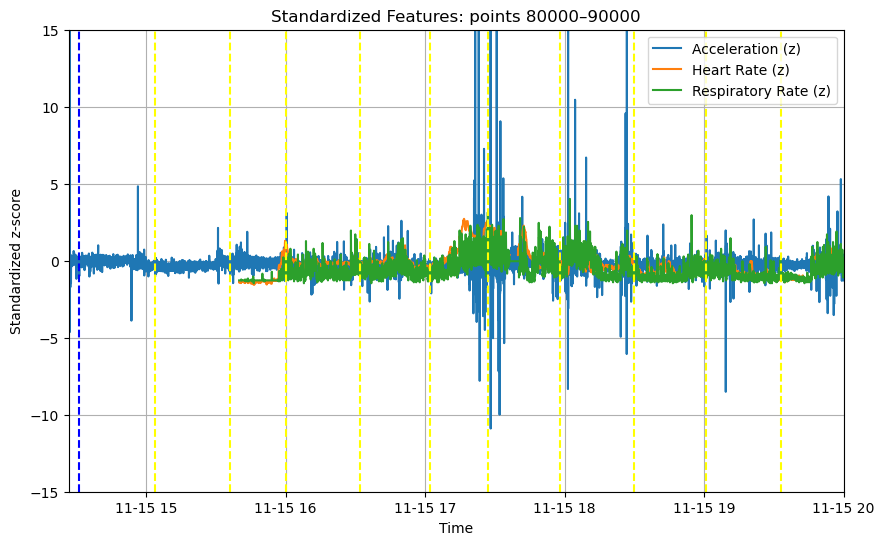

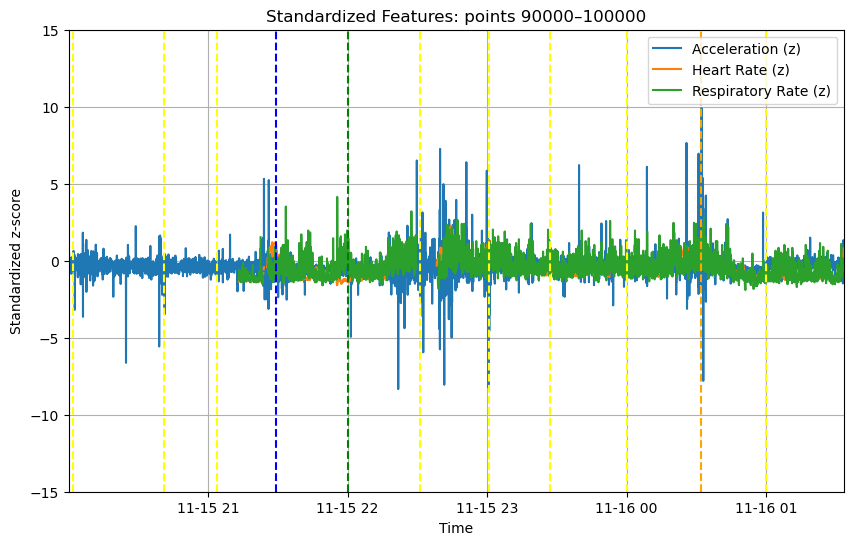

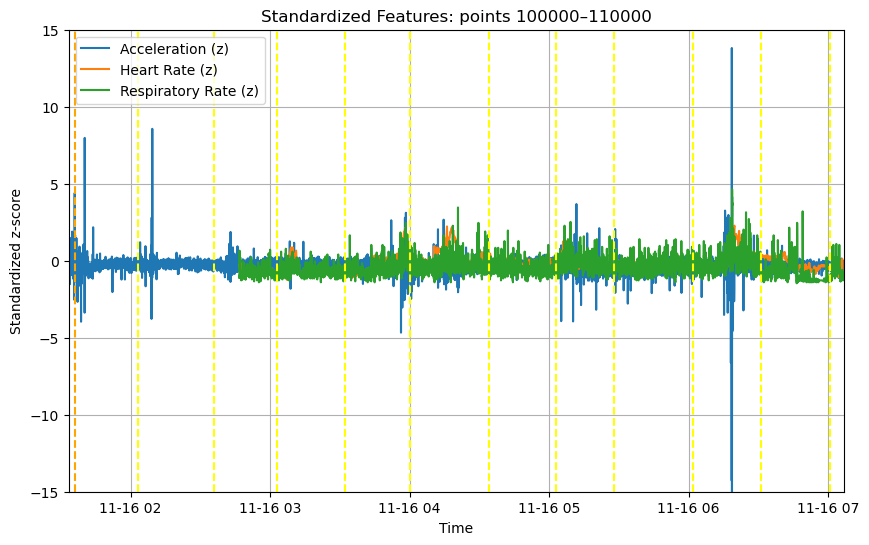

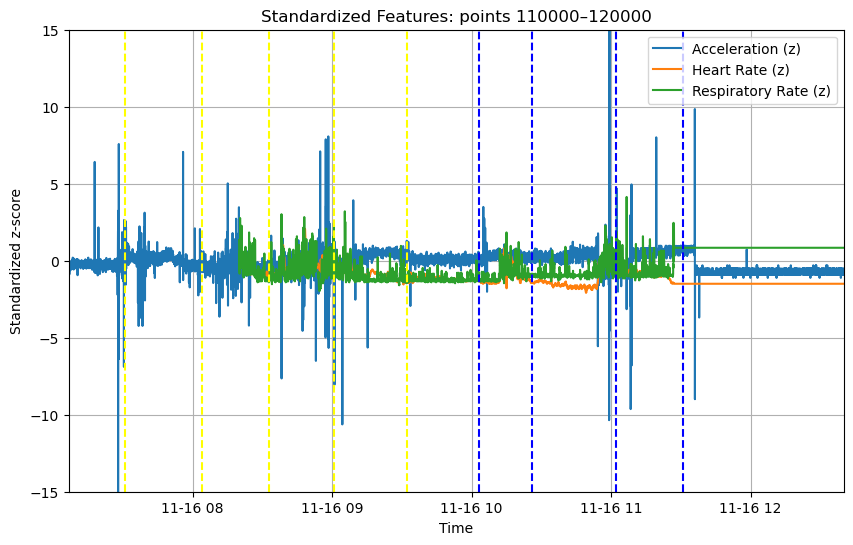

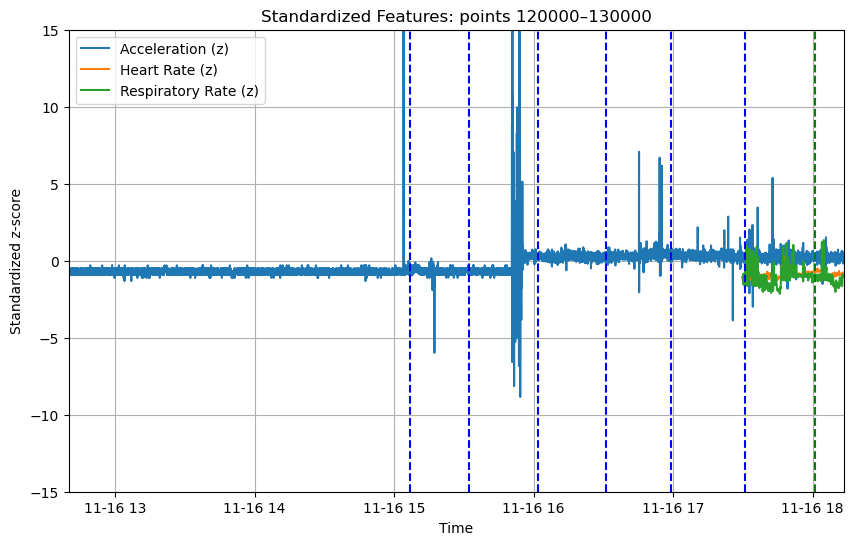

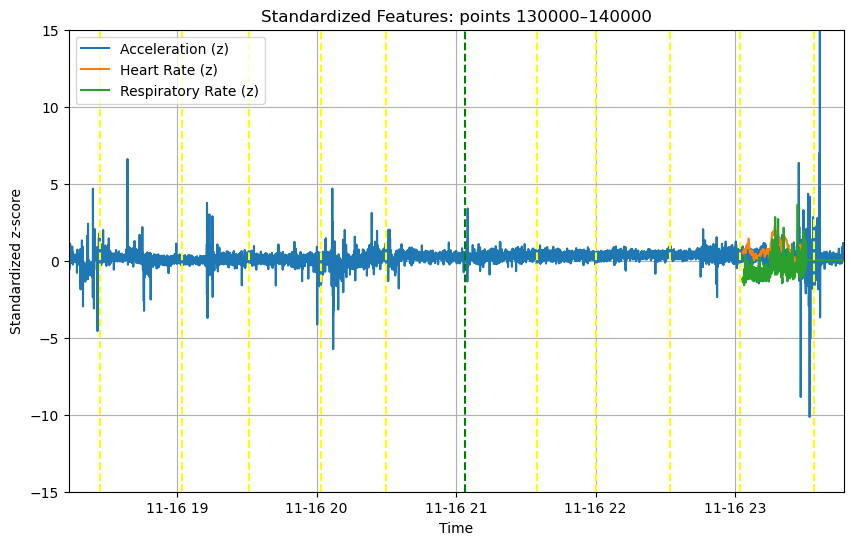

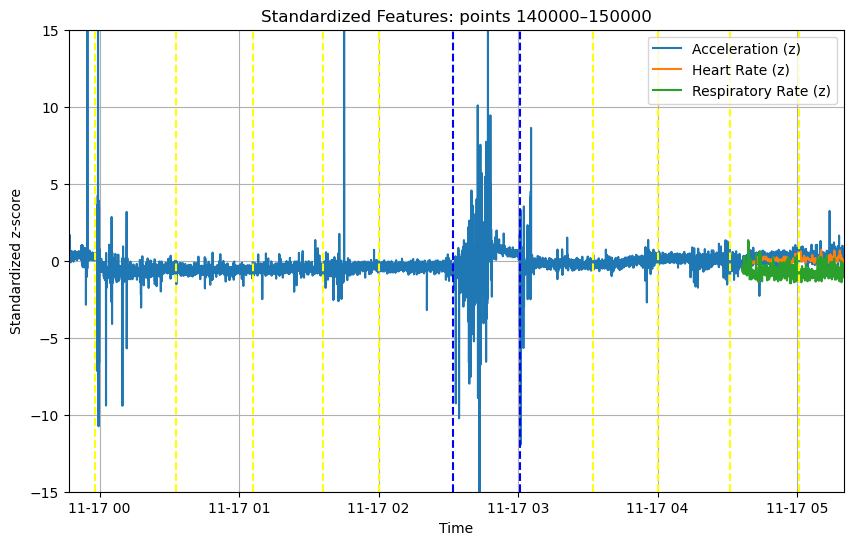

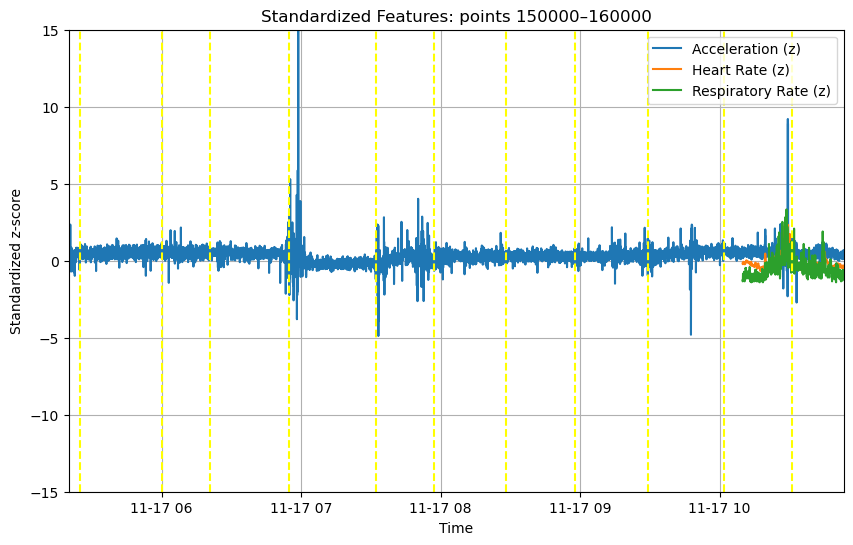

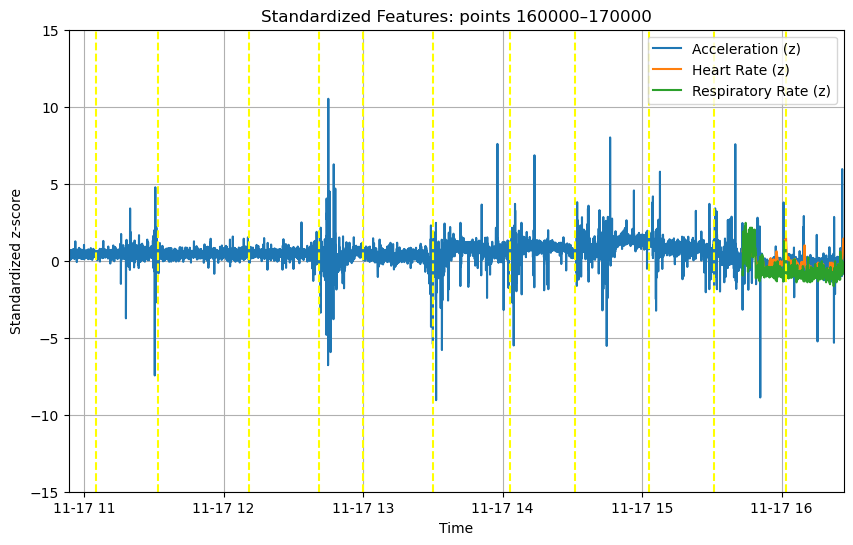

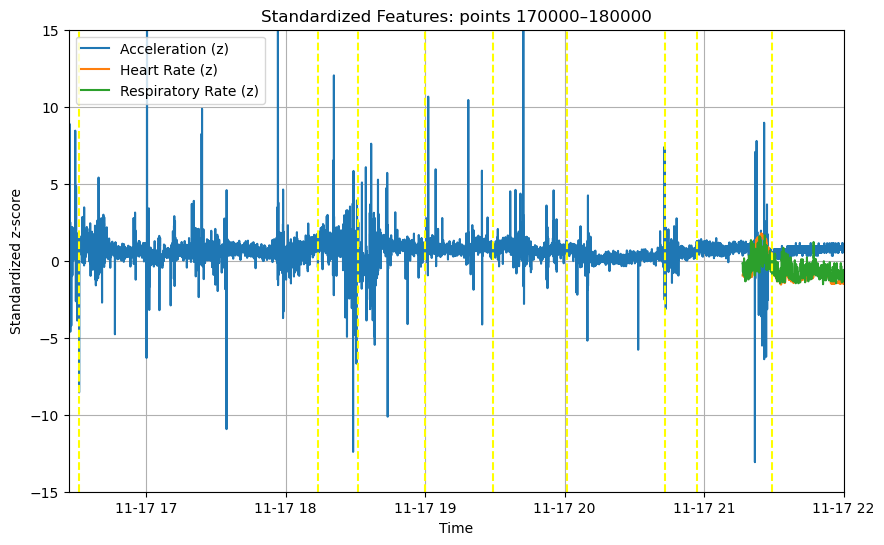

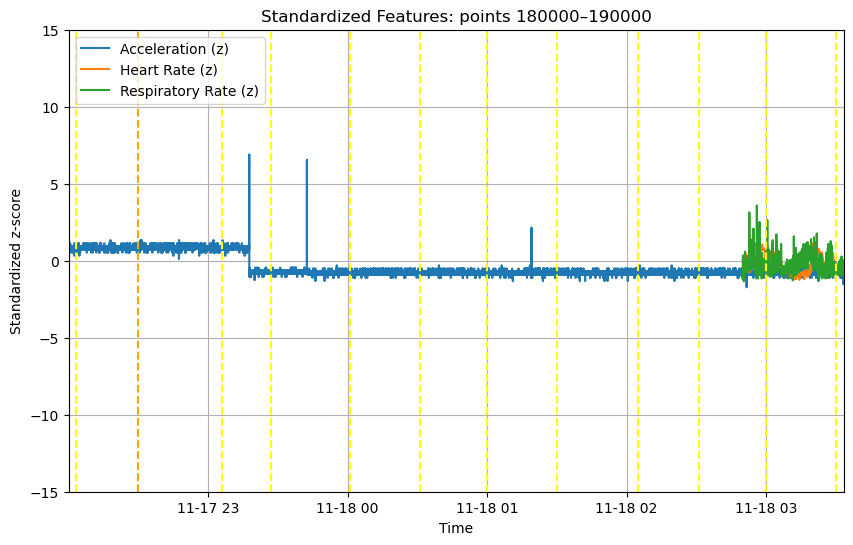

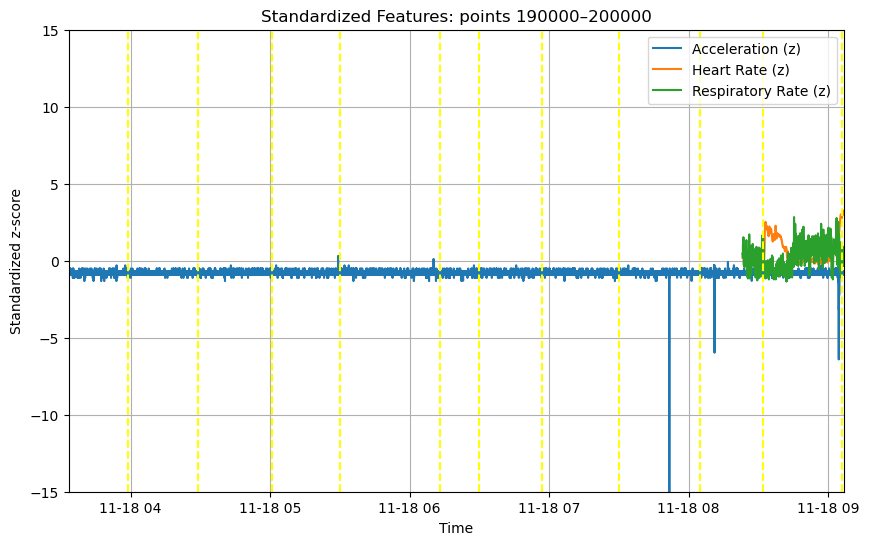

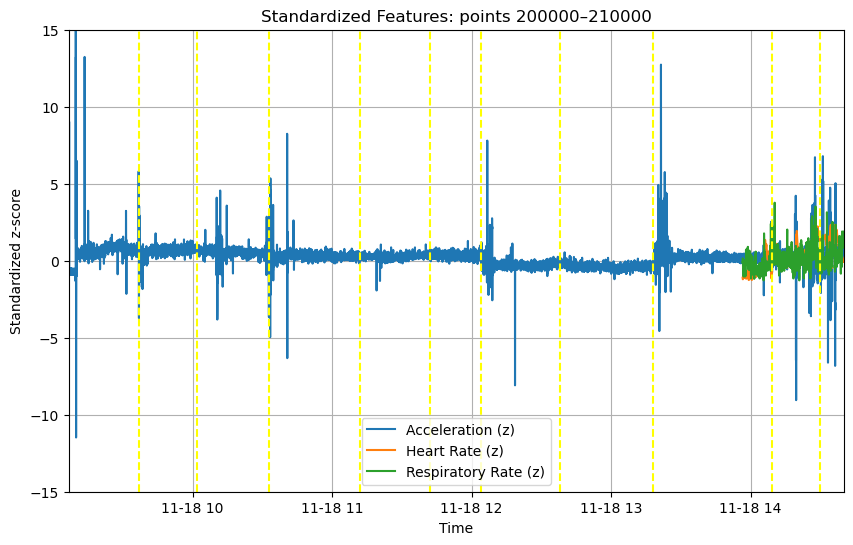

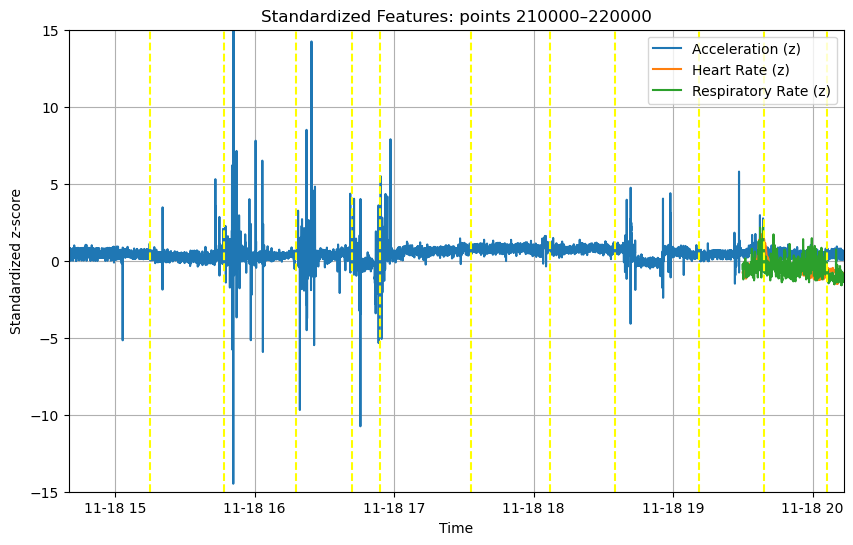

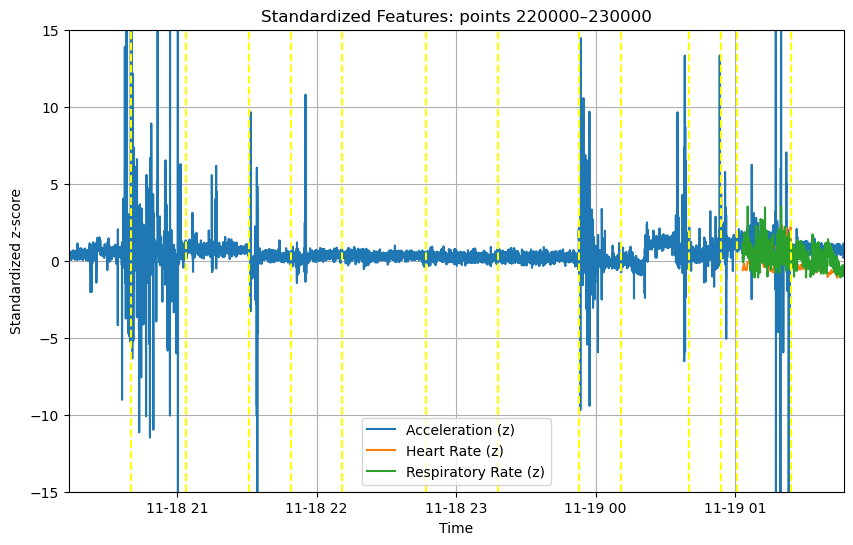

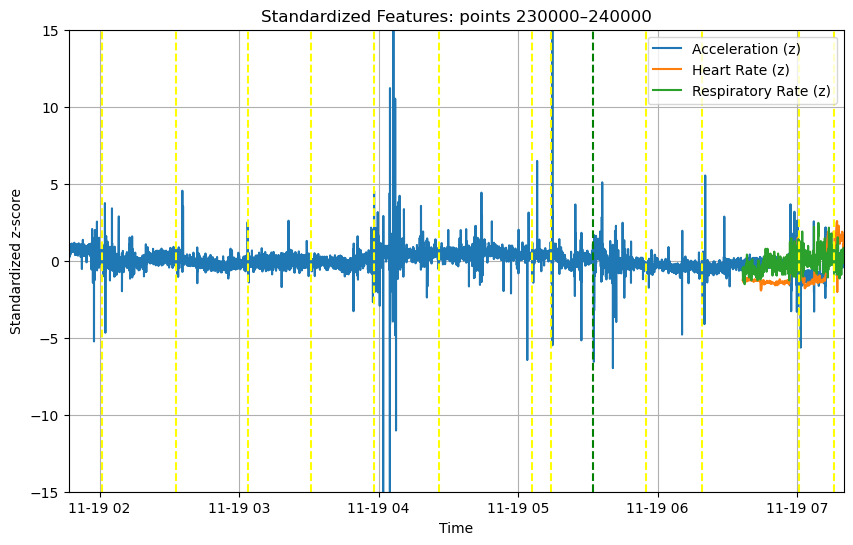

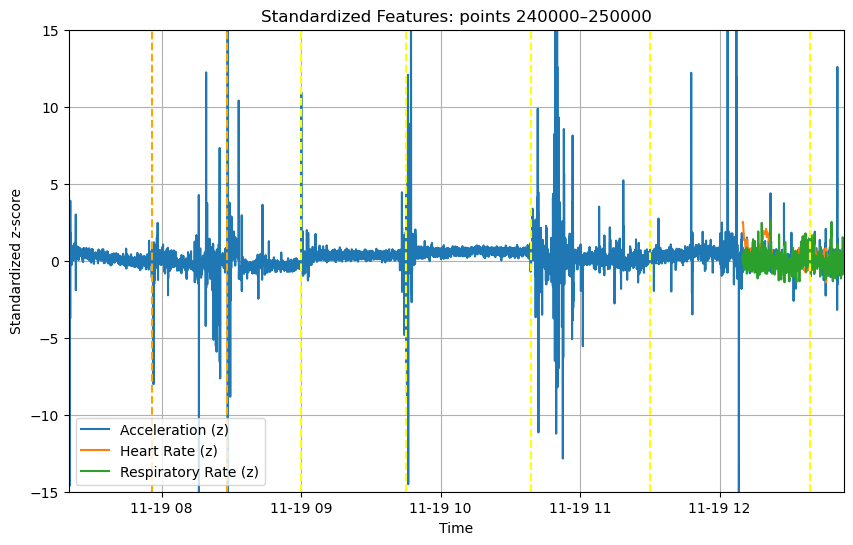

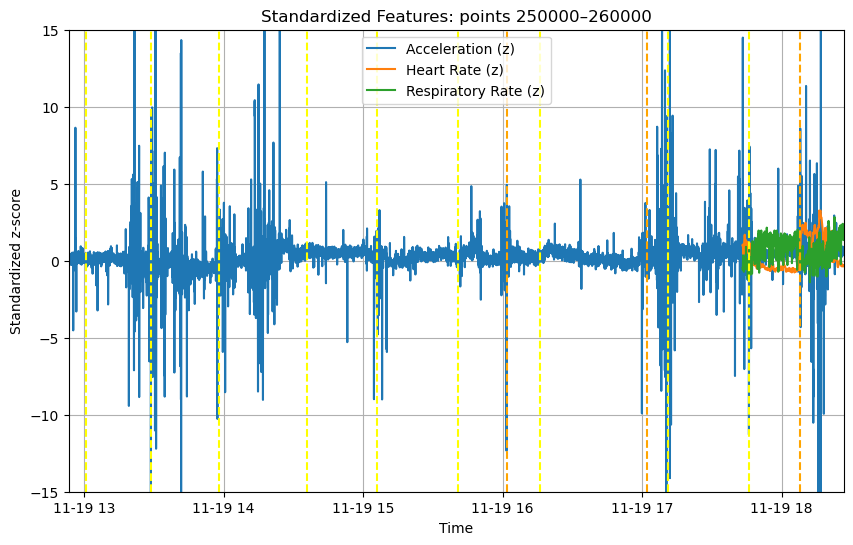

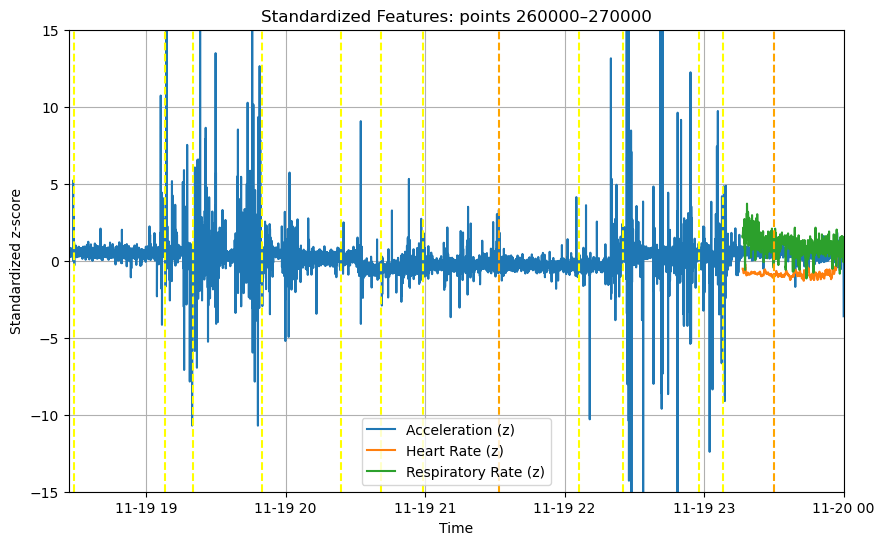

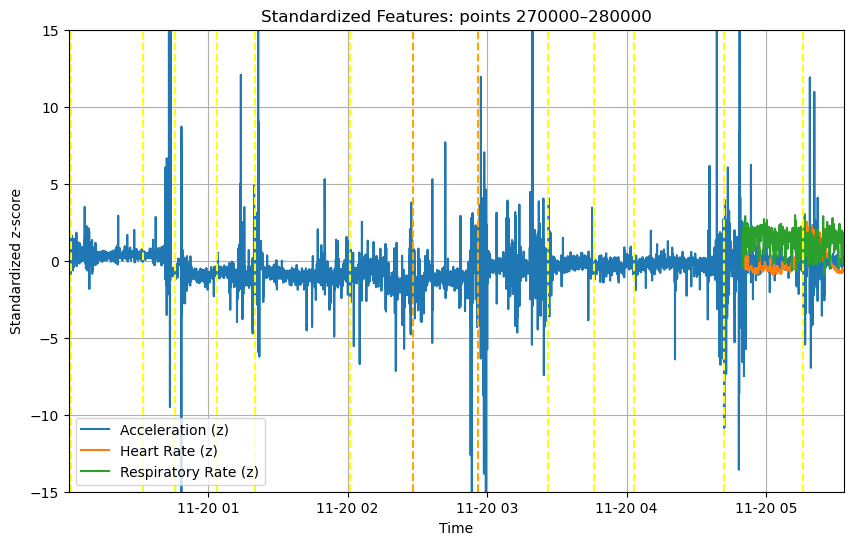

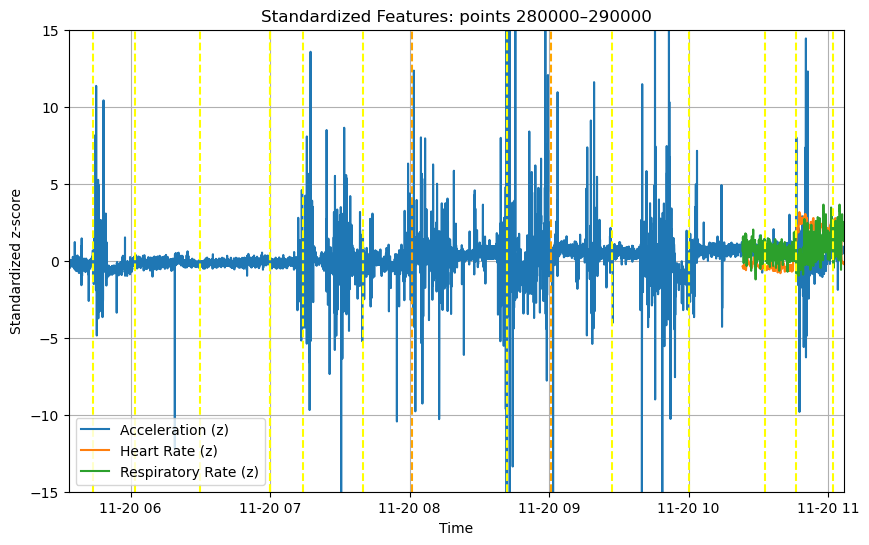

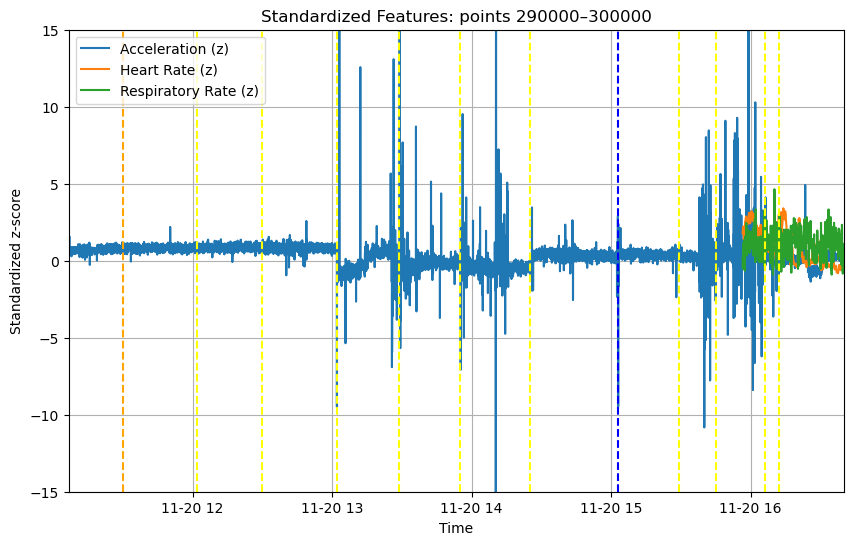

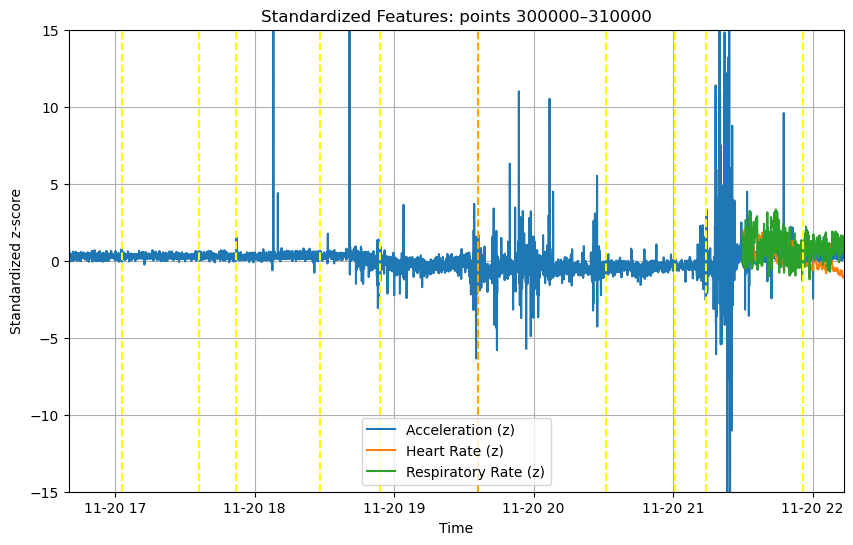

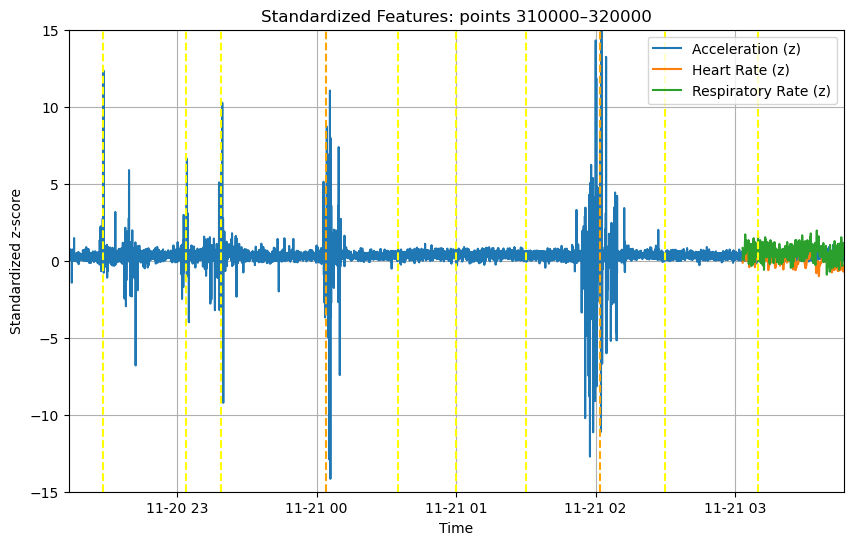

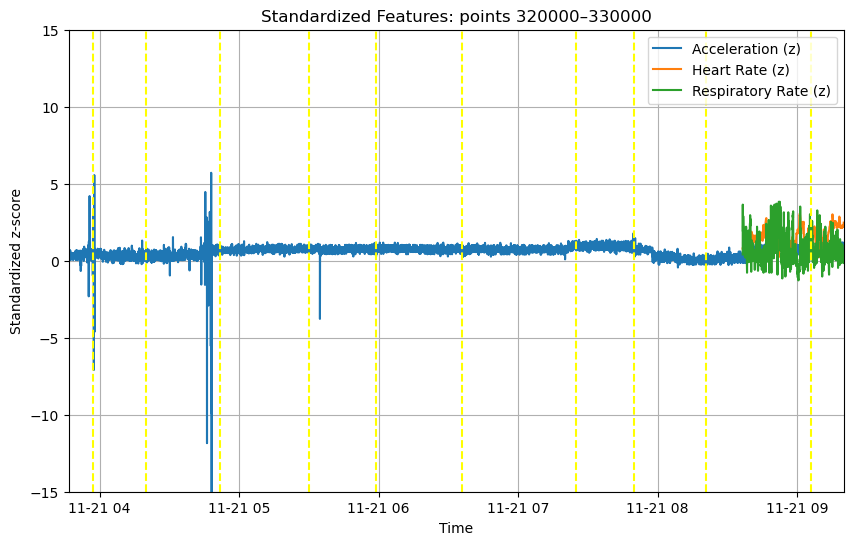

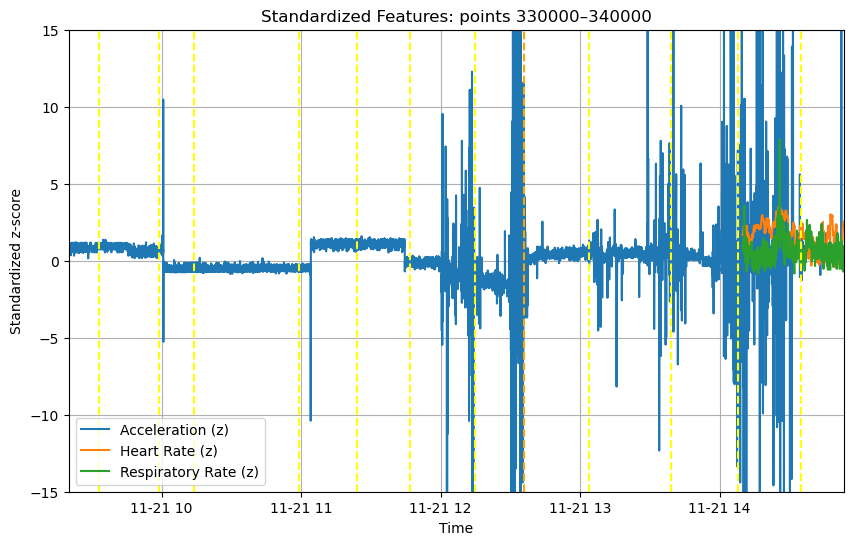

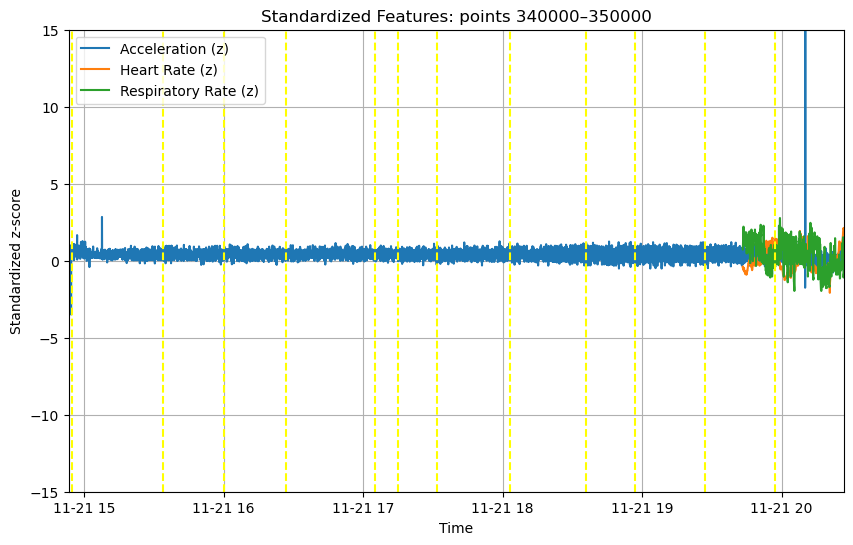

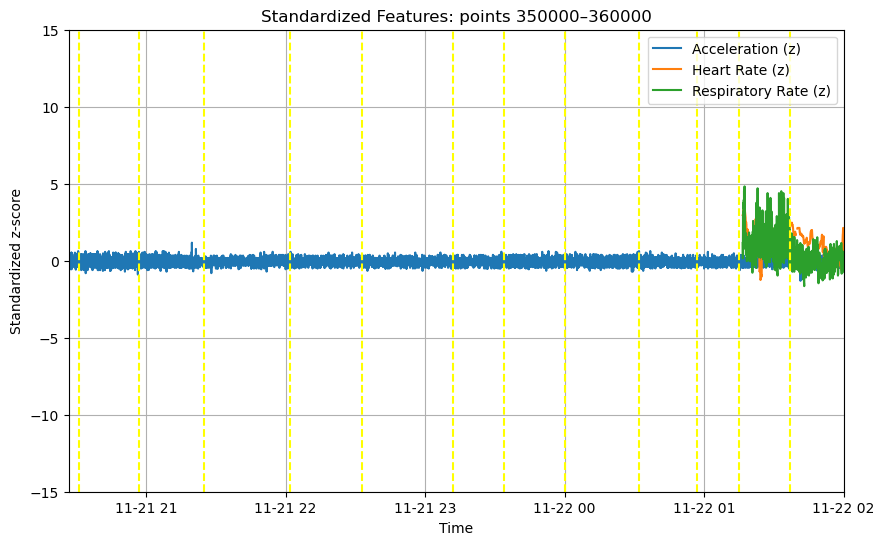

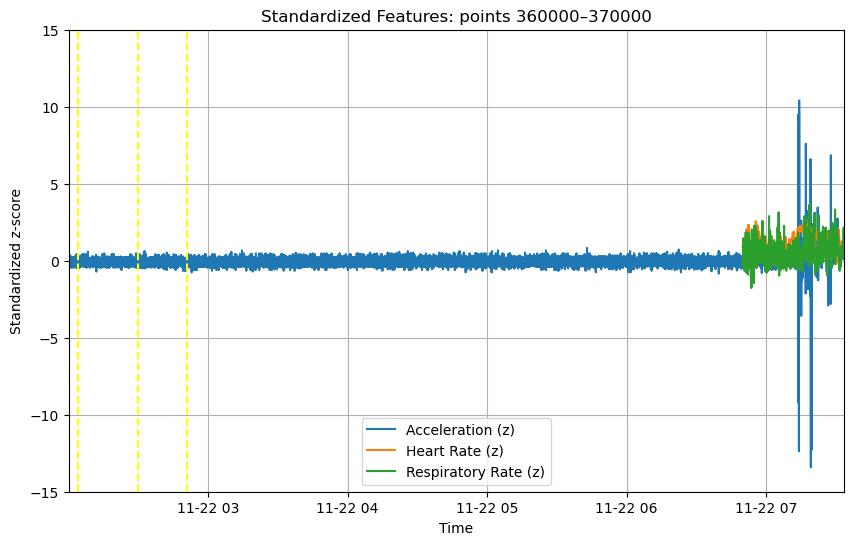

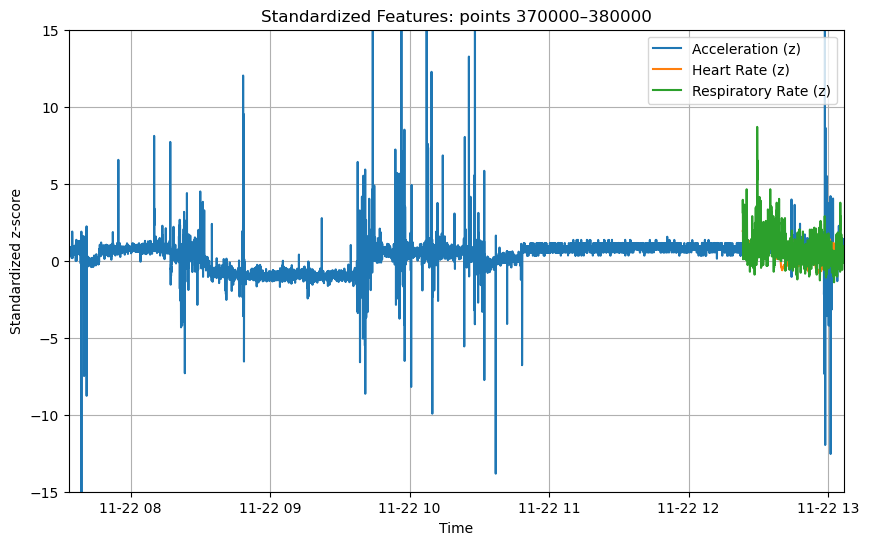

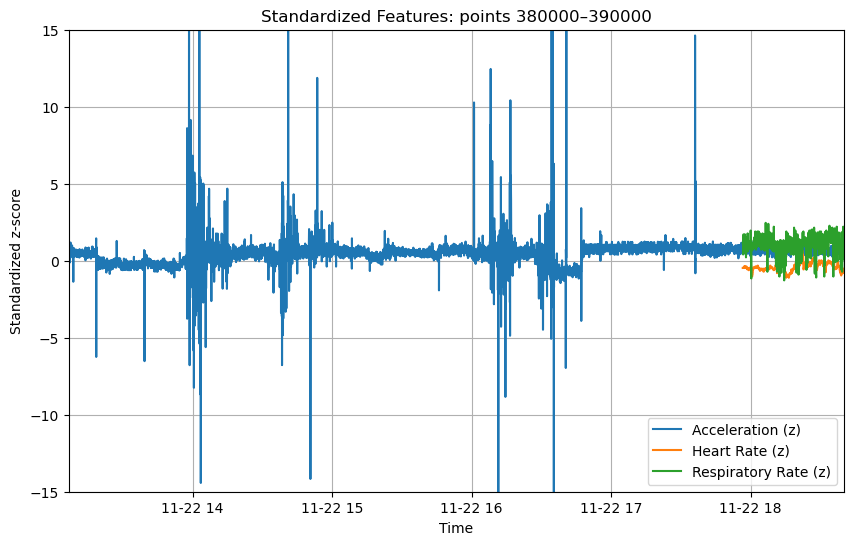

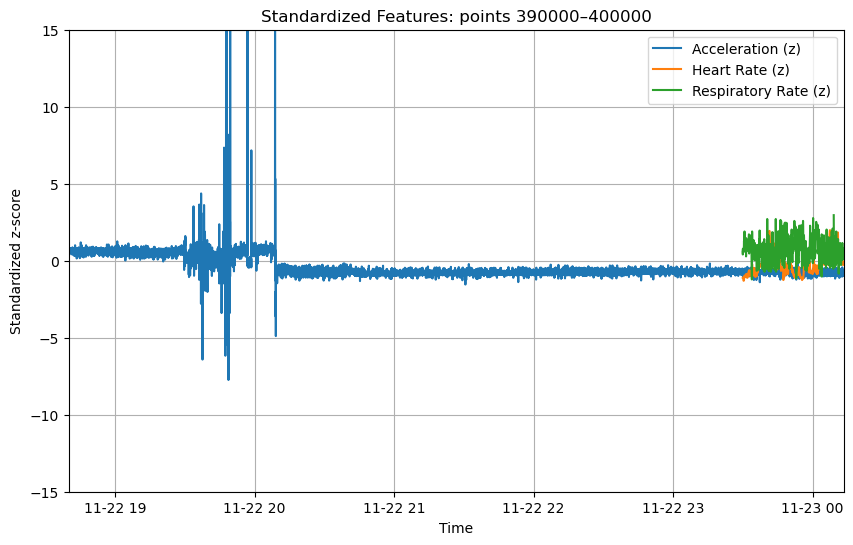

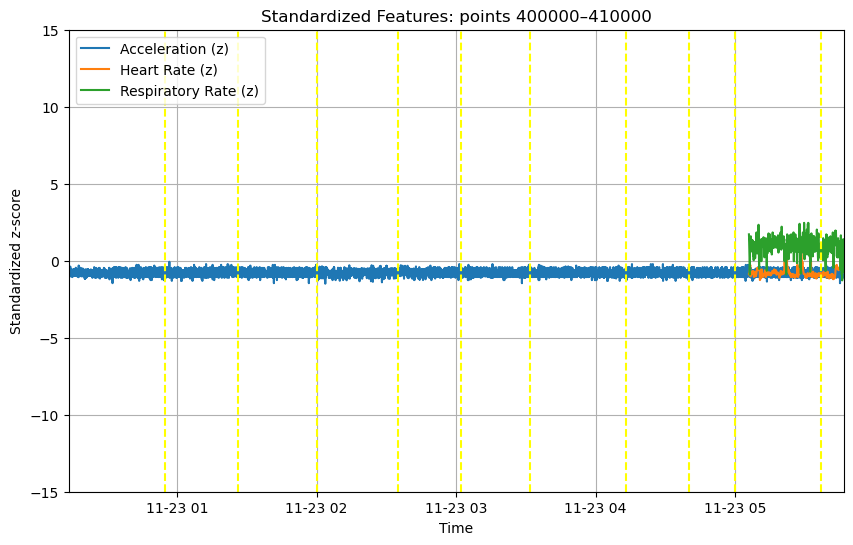

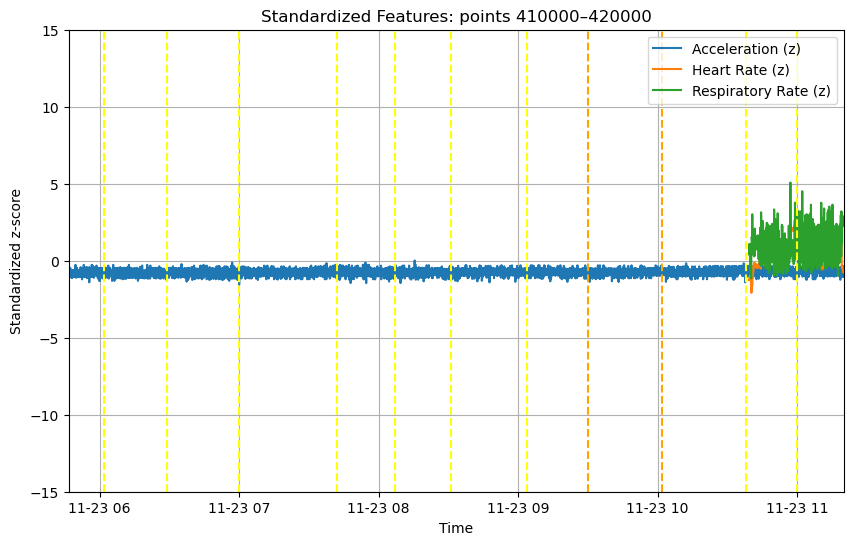

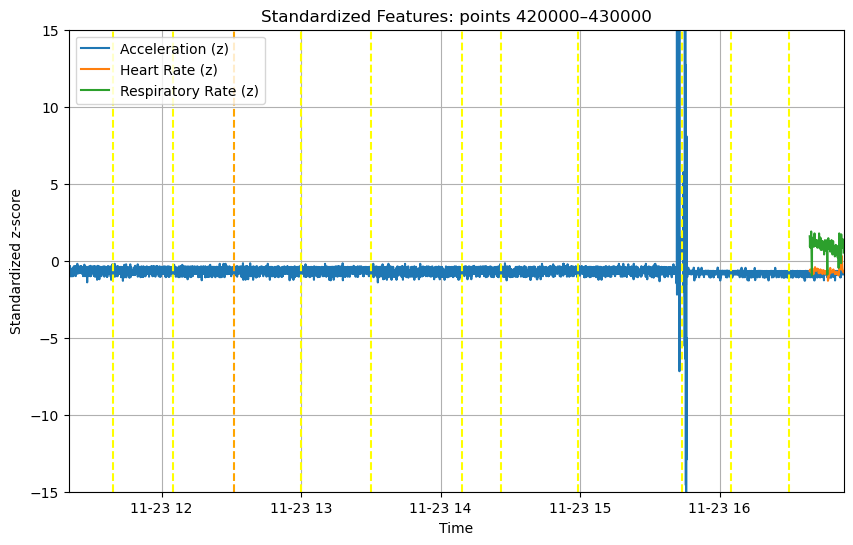

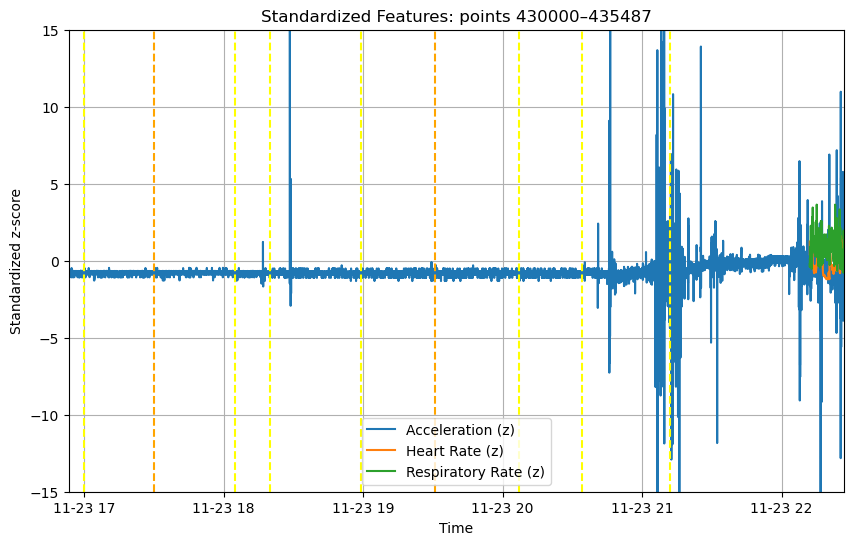

In [100]:
start = hr4['time'].iloc[0]
end = hr4['time'].iloc[-1]

accel4_downsampled = accel4_downsampled[['time', 'a']]

accel4_downsampled = accel4_downsampled[accel4_downsampled['time'].between(start, end)]
accel4_standardized = accel4_downsampled.copy()
accel4_standardized['a'] = (accel4_downsampled['a'] - accel4_downsampled['a'].mean()) / accel4_downsampled['a'].std()

hr4 = hr4[hr4['time'].between(start, end)]
hr4_standardized = hr4.copy()
hr4_standardized['heart_rate'] = (hr4['heart_rate'] - hr4['heart_rate'].mean()) / hr4['heart_rate'].std()

rr4= rr4[rr4['time'].between(start, end)]
rr4_standardized = rr4.copy()
rr4_standardized['respiratory_rate'] = (rr4['respiratory_rate'] - rr4['respiratory_rate'].mean()) / rr4['respiratory_rate'].std()

chunk_size = 10000

for start_idx in range(0, len(hr4_standardized), chunk_size):
    end_idx = start_idx + chunk_size

    accel_chunk = accel4_standardized.iloc[start_idx:end_idx]
    hr_chunk    = hr4_standardized.iloc[start_idx:end_idx]
    rr_chunk    = rr4_standardized.iloc[start_idx:end_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(accel_chunk['time'], accel_chunk['a'],              label='Acceleration (z)')
    plt.plot(hr_chunk['time'],    hr_chunk['heart_rate'],        label='Heart Rate (z)')
    plt.plot(rr_chunk['time'],    rr_chunk['respiratory_rate'],  label='Respiratory Rate (z)')
    
    window_start = accel_chunk['time'].iloc[0]
    window_end   = accel_chunk['time'].iloc[-1]
    events_in_window = sbs4[sbs4['time'].between(window_start, window_end)]
    color_map = {-2:'blue', -1:'green', 0:'yellow', 1:'orange', 2:'red'}
    for _, row in events_in_window.iterrows():
        plt.axvline(x=row['time'], color=color_map[row['TM_SBS']], linestyle='--')

    plt.xlim(window_start, window_end)
    plt.ylim(-15, 15)
    plt.xlabel('Time')
    plt.ylabel('Standardized z‑score')
    plt.title(f'Standardized Features: points {start_idx}–{min(end_idx,len(hr4_standardized))}')
    plt.legend()
    plt.grid()
    plt.show()


Hello World!

In [40]:
def binary_search(times, target, start, end):
    if start > end:
        return -1

    mid = (start + end) // 2

    if times[mid] == target:
        return mid
    elif times[mid] < target:
        return binary_search(times, target, mid + 1, end)
    else:
        return binary_search(times, target, start, mid - 1)

In [34]:
start = 0
end = len(accel4) - 1

indices = np.zeros(len(sbs4), dtype=int)
chunks = []

for i in range(len(sbs4)):
    index = binary_search(accel4['time'].values, sbs4['time'].values[i], start, end)
    indices[i] = index

    if index != -1:
        chunks.append(tuple([index - 100*60*15, index + 100*60*15]))
    else:
        chunks.append(tuple([0, 0]))

In [37]:
accel4_chunks = pd.DataFrame(columns=['time', 'accel_x', 'accel_y', 'accel_z'])

for i in tqdm(range(len(chunks))):
    if chunks[i][0] < 0:
        continue

    if chunks[i][1] >= len(accel4):
        continue

    time = accel4['time'].values[chunks[i][0]:chunks[i][1]]
    accelx = accel4['X'].values[chunks[i][0]:chunks[i][1]]
    accely = accel4['Y'].values[chunks[i][0]:chunks[i][1]]
    accelz = accel4['Z'].values[chunks[i][0]:chunks[i][1]]

    accel4_chunks = pd.concat([accel4_chunks, pd.DataFrame({'time': time, 'accel_x': accelx, 'accel_y': accely, 'accel_z': accelz})], ignore_index=True)
    accel4_chunks = accel4_chunks.sort_values(by='time', ascending=True).reset_index(drop=True)

100%|██████████| 446/446 [24:15<00:00,  3.26s/it]
